# Analisi Esplorativa dei Dati - FantaSanremo 2026 (Enriched)

"
    "Questo notebook verifica qualità, copertura e distribuzioni dei dati in `artisti_2026_enriched.json`
"
    "e nello storico unificato. L'obiettivo è capire **cosa c'è**, **cosa manca** e
"
    "se il dataset è sufficiente per prevedere il punteggio finale degli artisti.
"
    

In [1]:
# Import e setup
import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")


# Trova project root (funziona da qualunque cwd)
def find_project_root(start: Path) -> Path:
    for parent in [start] + list(start.parents):
        if (parent / "data").exists() and (parent / "backend").exists():
            return parent
    return start

PROJECT_ROOT = find_project_root(Path(".").resolve())
DATA_DIR = PROJECT_ROOT / "data"

ENRICHED = DATA_DIR / "artisti_2026_enriched.json"
STORICO = DATA_DIR / "storico_fantasanremo_unified.json"

print("Project root:", PROJECT_ROOT)
print("Data dir:", DATA_DIR)


Project root: /Users/crescenzodepalma/Projects/cdpcre/fantasanremo_team_builder
Data dir: /Users/crescenzodepalma/Projects/cdpcre/fantasanremo_team_builder/data


In [2]:
# Caricamento dati
with open(ENRICHED, encoding="utf-8") as f:
    enriched = json.load(f)

with open(STORICO, encoding="utf-8") as f:
    storico = json.load(f)

# Classifiche finali (fonte principale per il training ML)
CLASSIFICHE = DATA_DIR / "classifiche_finali.json"
with open(CLASSIFICHE, encoding="utf-8") as f:
    classifiche = json.load(f)

# Voti stampa
VOTI_STAMPA = DATA_DIR / "voti_stampa.json"
voti_stampa = {}
if VOTI_STAMPA.exists():
    with open(VOTI_STAMPA, encoding="utf-8") as f:
        voti_stampa = json.load(f)

# DataFrame artisti 2026
df_artisti = pd.DataFrame(enriched.get("artisti", []))
print(f"Artisti 2026: {len(df_artisti)}")

# DataFrame edizioni
edizioni = storico.get("festival_edizioni", {})
df_edizioni = pd.DataFrame(edizioni.values())
print(f"Edizioni storiche: {len(df_edizioni)}")

# DataFrame storico artisti (long)
rows = []
for nome, info in storico.get("artisti_storici", {}).items():
    for ed in info.get("edizioni", []):
        rows.append({"nome": nome, **ed})

df_storico = pd.DataFrame(rows)
print(f"Record storici artisti: {len(df_storico)}")

# DataFrame classifiche finali (tutti gli artisti classificati 2020-2025)
classifica_rows = []
for anno, ed in classifiche.get("edizioni", {}).items():
    for entry in ed.get("classifica_completa", []):
        classifica_rows.append({"anno": int(anno), **entry})
df_classifiche = pd.DataFrame(classifica_rows)
print(f"Record classifiche finali: {len(df_classifiche)} (fonte training ML)")

# Voti stampa disponibili
n_voti = sum(len(ed.get("voti", [])) for ed in voti_stampa.get("edizioni", {}).values())
print(f"Voti stampa: {n_voti}")

df_artisti.head()


Artisti 2026: 30
Edizioni storiche: 6
Record storici artisti: 18
Record classifiche finali: 161 (fonte training ML)
Voti stampa: 131


,storico_fantasanremo,quotazione,id,nome,anno_nascita,social_followers_total,social_followers_by_platform,social_followers_last_updated,viralita_social,storia_bonus_ottenuti,ad_personam_bonus_count,ad_personam_bonus_points,genere_musicale,prima_partecipazione,note,followers_by_platform
0,[],17,1,Tommaso Paradiso,1983.0,193000,{'youtube_channel': 193000},2025-04-14,79,0,0,0,Pop,NaN,NaN,NaN
1,"[{'anno': 2021, 'posizione': 8}, {'anno': 2025...",17,2,Fedez & Marco Masini,1987.0,2518897,"{'youtube_channel': 2486000, 'x_twitter_numeri...",2025-05-11,96,440,0,0,Hip-hop,2021.0,"Fedez: 1989 - hip hop, pop rap; Marco Masini: ...",NaN
2,"[{'anno': 2021, 'posizione': 9}]",16,3,Arisa,1982.0,571723,"{'x_twitter_numeric': 479323, 'youtube_channel...",2025-02-01,86,235,1,10,Pop,2021.0,NaN,NaN
3,"[{'anno': 2022, 'posizione': 2}, {'anno': 2024...",16,4,Dargen D'Amico,1980.0,649708,"{'instagram': 320000, 'youtube_channel': 15400...",2026-02-07,87,855,0,0,Pop,2022.0,NaN,"{'instagram': 320000, 'youtube_channel': 15400..."
4,"[{'anno': 2021, 'posizione': 5}]",16,5,Ermal Meta,1981.0,665306,"{'x_twitter_numeric': 270306, 'youtube_channel...",2025-05-18,87,275,0,0,Pop,2021.0,NaN,NaN


## 1. Check di qualità (schema + missingness)

Controlliamo se i campi fondamentali ci sono e quanta copertura hanno.

In [3]:
# Campi minimi attesi
required_cols = ["id", "nome", "quotazione"]
missing_required = [c for c in required_cols if c not in df_artisti.columns]
print("Missing required columns:", missing_required)

# Duplicati per nome
print("Duplicati nome:", df_artisti["nome"].duplicated().sum())

# Missingness per campi chiave
key_cols = [
    "anno_nascita",
    "genere_musicale",
    "prima_partecipazione",
    "viralita_social",
    "social_followers_total",
    "storia_bonus_ottenuti",
    "ad_personam_bonus_points",
]

missing = df_artisti[key_cols].isna().mean().sort_values(ascending=False) * 100
print("\n--- Missingness artisti 2026 (%) ---")
print(missing)

# Quality check: classifiche finali
print("\n--- Quality check: classifiche_finali.json ---")
print(f"Anni disponibili: {sorted(df_classifiche['anno'].unique())}")
print(f"Artisti per anno:")
print(df_classifiche.groupby("anno")["artista"].count())
print(f"Totale record: {len(df_classifiche)} (usati come training samples)")

# Quality check: voti stampa
print("\n--- Quality check: voti_stampa.json ---")
for anno, ed in voti_stampa.get("edizioni", {}).items():
    voti = ed.get("voti", [])
    print(f"  {anno}: {len(voti)} voti stampa")


Missing required columns: []
Duplicati nome: 0

--- Missingness artisti 2026 (%) ---
prima_partecipazione        53.333333
anno_nascita                 3.333333
genere_musicale              0.000000
viralita_social              0.000000
social_followers_total       0.000000
storia_bonus_ottenuti        0.000000
ad_personam_bonus_points     0.000000
dtype: float64

--- Quality check: classifiche_finali.json ---
Anni disponibili: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Artisti per anno:
anno
2020    23
2021    26
2022    25
2023    28
2024    30
2025    29
Name: artista, dtype: int64
Totale record: 161 (usati come training samples)

--- Quality check: voti_stampa.json ---
  2026: 30 voti stampa
  2025: 22 voti stampa
  2024: 22 voti stampa
  2023: 17 voti stampa
  2022: 14 voti stampa
  2021: 14 voti stampa
  2020: 12 voti stampa


## 2. Distribuzioni principali

Verifichiamo se le variabili hanno distribuzioni sane e outlier evidenti.

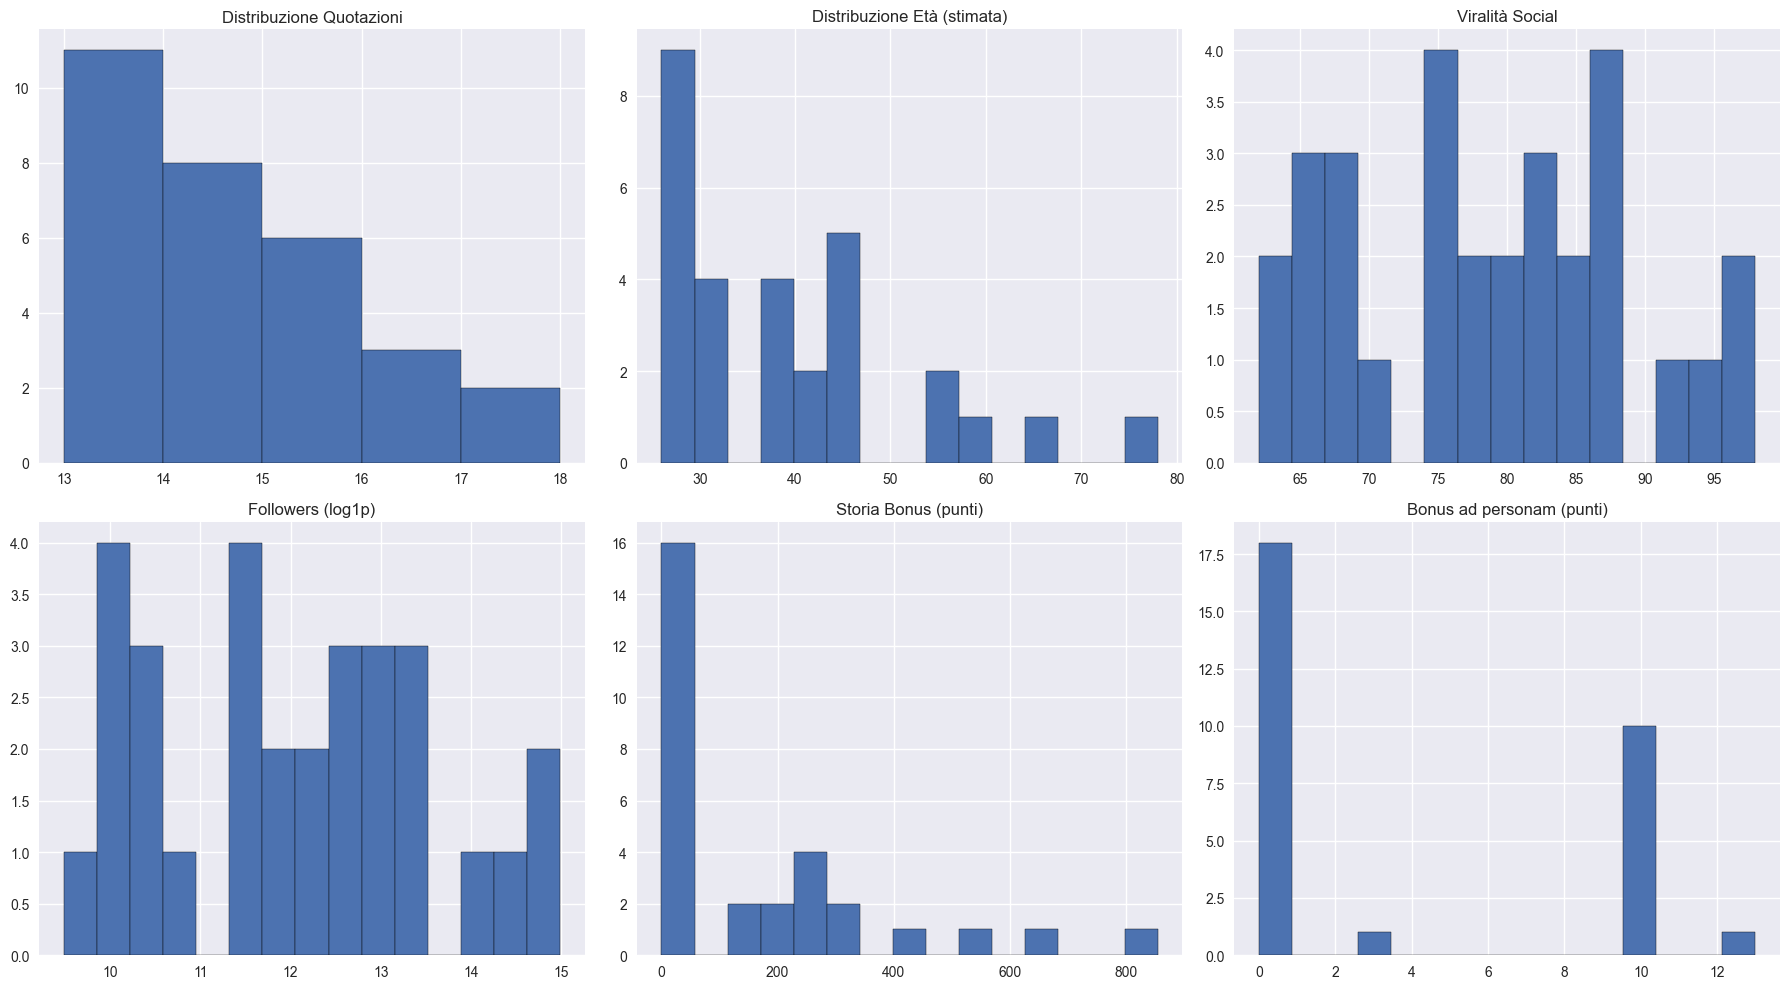

In [4]:
# Età stimata
df_artisti["eta_2026"] = 2026 - df_artisti["anno_nascita"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Quotazione
axes[0, 0].hist(df_artisti["quotazione"].dropna(), bins=range(13, 19), edgecolor="black")
axes[0, 0].set_title("Distribuzione Quotazioni")

# Età
axes[0, 1].hist(df_artisti["eta_2026"].dropna(), bins=15, edgecolor="black")
axes[0, 1].set_title("Distribuzione Età (stimata)")

# Viralità
axes[0, 2].hist(df_artisti["viralita_social"].dropna(), bins=15, edgecolor="black")
axes[0, 2].set_title("Viralità Social")

# Followers (log)
followers = df_artisti["social_followers_total"].dropna()
axes[1, 0].hist(np.log1p(followers), bins=15, edgecolor="black")
axes[1, 0].set_title("Followers (log1p)")

# Bonus storici
axes[1, 1].hist(df_artisti["storia_bonus_ottenuti"].dropna(), bins=15, edgecolor="black")
axes[1, 1].set_title("Storia Bonus (punti)")

# Bonus ad personam
axes[1, 2].hist(df_artisti["ad_personam_bonus_points"].dropna(), bins=15, edgecolor="black")
axes[1, 2].set_title("Bonus ad personam (punti)")

plt.tight_layout()


## 3. Copertura storico (quanti artisti hanno dati storici)

In [5]:
from backend.utils.name_normalization import normalize_artist_name

current = {normalize_artist_name(n) for n in df_artisti["nome"].dropna()}
historical = {normalize_artist_name(n) for n in storico.get("artisti_storici", {}).keys()}

with_history = len(current & historical)
print(f"Artisti con storico: {with_history} / {len(current)}")

# Distribuzione record storici
if not df_storico.empty:
    print(df_storico.groupby("nome")["anno"].count().describe())


Artisti con storico: 14 / 30
count    14.000000
mean      1.285714
std       0.468807
min       1.000000
25%       1.000000
50%       1.000000
75%       1.750000
max       2.000000
Name: anno, dtype: float64


## 4. Data readiness per ML

Usiamo il `FeatureBuilder` per verificare quanti campioni di training abbiamo e il set di 40+ feature.
La pipeline usa `classifiche_finali.json` come fonte principale (108 campioni, 2020-2025).

In [6]:
from backend.ml.feature_builder import FeatureBuilder

builder = FeatureBuilder()
sources = builder.load_sources()
features_df = builder.build_training_frame(sources)

# Split per anno (come in train.py)
splits = builder.split_by_years(
    features_df, builder.config.training_years, builder.config.validation_years
)
train_df = splits["train"]

# Feature disponibili
feature_cols = builder.get_feature_columns(features_df)

print("=== ML Data Readiness ===")
print(f"Campioni di training: {len(train_df)} (da classifiche_finali.json)")
print(f"Feature disponibili: {len(feature_cols)} (40+ engineered)")
print(f"Anni di training: {sorted(train_df['anno'].unique().tolist())}")
print(f"Anni di validazione: {list(splits['val'].keys())}")
for year, val_df in splits["val"].items():
    print(f"  Val {year}: {len(val_df)} campioni")
print(f"\nCampioni per anno (training):")
print(train_df.groupby("anno")["artista_id"].count())

# Missingness sulle feature
missing_feat = features_df[feature_cols].isna().mean().sort_values(ascending=False)
print(f"\nTop 10 feature con piu missing:")
print(missing_feat.head(10))

2026-02-09 14:42:03,205 - MLDataPreparation - INFO - Training years: [2020, 2021, 2022, 2024]
2026-02-09 14:42:03,205 - MLDataPreparation - INFO - Validation years: [2023, 2025]
2026-02-09 14:42:03,207 - MLDataPreparation - INFO - Loaded artisti_2026: 30 artists
2026-02-09 14:42:03,208 - MLDataPreparation - INFO - Loaded storico_unified
2026-02-09 14:42:03,208 - MLDataPreparation - INFO - Loaded biografico: 30 entries
2026-02-09 14:42:03,209 - MLDataPreparation - INFO - Loaded caratteristiche: 30 entries
2026-02-09 14:42:03,209 - MLDataPreparation - INFO - Loaded regolamento_2026
2026-02-09 14:42:03,210 - MLDataPreparation - INFO - Loaded classifiche_finali
2026-02-09 14:42:03,211 - MLDataPreparation - INFO - Loaded voti_stampa
2026-02-09 14:42:03,219 - MLDataPreparation - INFO - Built historical dataframe: 167 records, 131 unique artists
2026-02-09 14:42:03,223 - MLDataPreparation - INFO - Calculated 167 real scores from historical data


=== ML Data Readiness ===
Campioni di training: 108 (da classifiche_finali.json)
Feature disponibili: 72 (40+ engineered)
Anni di training: [2020, 2021, 2022, 2024]
Anni di validazione: [2023, 2025]
  Val 2023: 29 campioni
  Val 2025: 30 campioni

Campioni per anno (training):
anno
2020    23
2021    27
2022    27
2024    31
Name: artista_id, dtype: int64

Top 10 feature con piu missing:
voto_stampa                 0.0
participations              0.0
age_genre_mainstream_pop    0.0
DEBUTTANTE_POTENTIAL        0.0
LEGENDARY_STATUS            0.0
POP_MAINSTREAM              0.0
RAP_TRAP_STAR               0.0
INDIE_DARLING               0.0
VETERAN_PERFORMER           0.0
VIRAL_PHENOMENON            0.0
dtype: float64


## 6. Conclusioni operative

- **Training data**: 108 campioni da `classifiche_finali.json` (tutti gli artisti classificati 2020-2025)
- **Feature set**: 40+ feature ingegnerizzate in 6 categorie (historical, genre, biographical, regulatory, caratteristiche, archetypes)
- **Validazione**: Split temporale — train su 2020+2021+2022+2024, validazione su 2023 e 2025
- **Target**: punteggio reale stimato da posizione, normalizzato Z-score per anno
- **Pipeline**: `train.py` come single source of truth, notebook per esplorazione/visualizzazione

2026-02-09 14:42:03,320 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-09 14:42:03,321 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Statistiche punteggi per anno:
            mean         std         min         max  count
anno                                                       
2020  136.043269   33.407925   81.860242  190.226297     23
2021  190.660483   54.420516   96.050734  275.000000     27
2022  313.066372   84.443573  171.839140  453.949118     27
2023  364.027237  133.659503  128.000000  579.325541     29
2024  272.707491  100.763738  104.667022  460.000000     31
2025  260.596545   89.268363  112.933114  410.715868     30


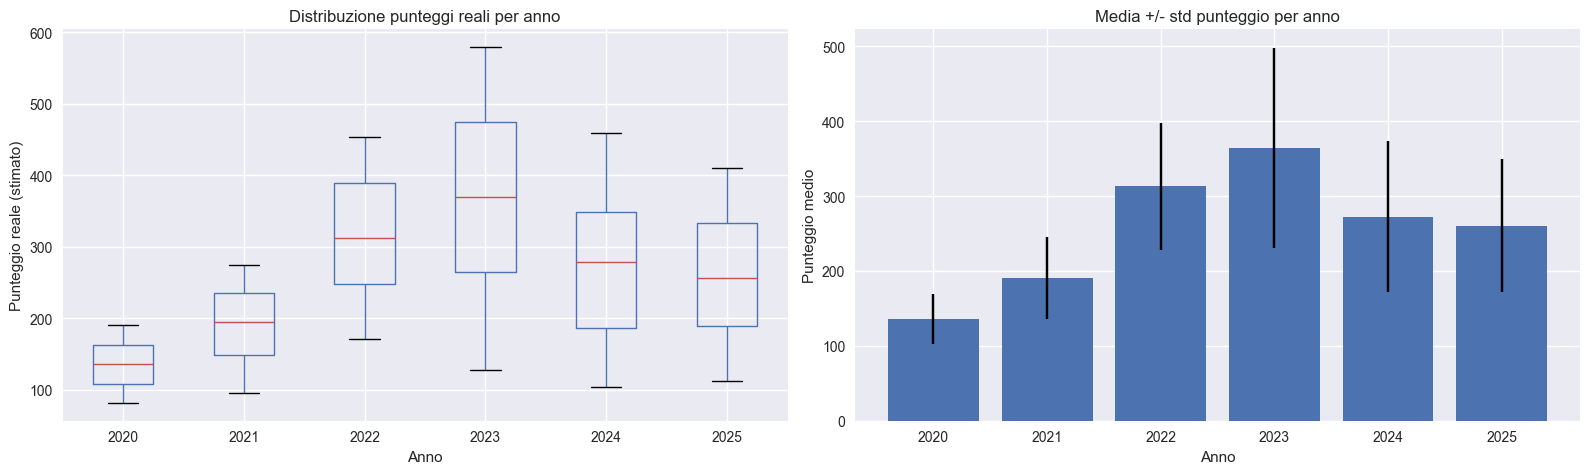

In [7]:
# Distribuzione punteggi reali per anno
scored_df = features_df[features_df["punteggio_reale"].notna()].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Box plot per anno
scored_df.boxplot(column="punteggio_reale", by="anno", ax=axes[0])
axes[0].set_title("Distribuzione punteggi reali per anno")
axes[0].set_xlabel("Anno")
axes[0].set_ylabel("Punteggio reale (stimato)")
axes[0].get_figure().suptitle("")

# Statistiche per anno
year_stats = scored_df.groupby("anno")["punteggio_reale"].agg(["mean", "std", "min", "max", "count"])
axes[1].bar(year_stats.index.astype(str), year_stats["mean"], yerr=year_stats["std"], capsize=5)
axes[1].set_title("Media +/- std punteggio per anno")
axes[1].set_xlabel("Anno")
axes[1].set_ylabel("Punteggio medio")

plt.tight_layout()

print("Statistiche punteggi per anno:")
print(year_stats.to_string())


## 5. Conclusioni operative

- **Output consigliato**: punteggio finale previsto per ogni artista (regressione).
- **Metriche principali**: MAE + Spearman (ranking).
- **Attenzione**: pochi record storici reali → usare modelli semplici e validazione temporale.
